# Export DEM for Cergy-Pontoise for use in GOCAD

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Import pandas and geopandas
import pandas as pd
import geopandas as pgd

# Projections for coordinates
from pyproj import Proj
import rasterio as rio
from osgeo import gdal

# To download DEM
import elevation

Get picks and from their locations select the DEM

In [2]:
file = '/work/armitagj/skua/TIGA/horizons_test.txt'
colnames = ['horizon', 'X', 'Y', 'Z']
df = pd.read_csv(file, names=colnames, header=None)
df['Z'] = -df['Z']

# picks for georeferencing
file = '/work/armitagj/skua/TIGA/georeference_test.txt'
colnames = ['X', 'Y', 'Lat', 'Long']
refdf = pd.read_csv(file, names=colnames, header=None)

# linear regression for change of coordinates
mxlong, cxlong = np.linalg.lstsq(np.vstack([refdf.X, np.ones(len(refdf))]).T, refdf.Long, rcond=None)[0]
mylat, cylat = np.linalg.lstsq(np.vstack([refdf.Y, np.ones(len(refdf))]).T, refdf.Lat, rcond=None)[0]
df['Long'] = df['X']*mxlong + cxlong
df['Lat'] = df['Y']*mylat + cylat

# project into EPSG:32631
myProj = Proj("+proj=utm +zone=31N, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
df['UTMx'], df['UTMy'] = myProj(df['Long'].values, df['Lat'].values)

Get topography data

In [3]:
minlon = df.Long.min()-0.01
maxlon = df.Long.max()+0.01
minlat = df.Lat.min()-0.01
maxlat = df.Lat.max()+0.01

# Create a temporary file to store the DEM and go get it using elevation
dem_path = 'tmp.tif'
output = os.getcwd() + '/' + dem_path
elevation.clip(bounds=(minlon, minlat, maxlon, maxlat), output=output, product='SRTM1')

Export lat/long topo to ascii format

In [4]:
def tif2asc(tiffile, ascfile):
    """
    Function to convert a geotiff (.tif) file into an ascii file (.asc)
    :param tiffile: input geotiff file name
    :param ascfile: output ascii file name (CAESAR expects .asc)
    :return: None
    """
    rio_array = rio.open(tiffile)  # read in tif file
    data_array = rio_array.read(1)  # assume that elevation is in the first band

    f = open(ascfile, 'w')
    f.write('ncols         {}\n'.format(np.int(np.shape(data_array)[1]) + 1))
    f.write('nrows         {}\n'.format(np.int(np.shape(data_array)[0]) + 1))
    f.write('xllcorner     {}\n'.format((rio_array.transform * (0, rio_array.height))[0]))
    f.write('yllcorner     {}\n'.format((rio_array.transform * (0, rio_array.height))[1]))
    f.write('cellsize      {}\n'.format(rio_array.transform[0]))
    f.write('NODATA_value  -9999\n')

    pix = '{0} '
    for i in range(0, np.shape(data_array)[0], 10):
        for j in range(0, np.shape(data_array)[1], 10):
            if np.isnan(data_array[i, j]) == True:
                f.write(pix.format(np.int(-9999)))  # need to replace nan with -9999
            else:
                f.write(pix.format(data_array[i, j]))
        f.write("\n")
    f.close()

In [5]:
asc_path = 'tmp.asc'
tif2asc(dem_path, asc_path)

In [6]:
!ls

Cergy-Pontoise-DEM.ipynb	 lith_block.npy       tmp.tif
Cergy-Pontoise-GemPy.ipynb	 structured_cube.png  tmpUTM.tif
Cergy-Pontoise-ipyleaflet.ipynb  testLatLon.tif       x-coord.npy
Cergy-Pontoise-Model.ipynb	 test.tif	      y-coord.npy
checkpoint1.pickle		 tiga-model.vtr       z-coord.npy
first_shot.png			 tileset
foo.vtkjs			 tmp.asc


<function matplotlib.pyplot.show(close=None, block=None)>

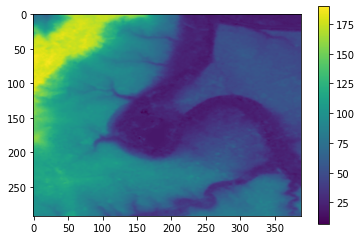

In [40]:
rio_array = rio.open(dem_path)
data_array = rio_array.read(1)
plt.figure()
plt.imshow(np.flipud(data_array))
plt.colorbar()
plt.show

In [16]:
ncols = np.int(np.shape(data_array)[1])
nrows = np.int(np.shape(data_array)[0])

xllcorner = (rio_array.transform * (0, rio_array.height))[0]
yllcorner = (rio_array.transform * (0, rio_array.height))[1]
cellsize = rio_array.transform[0]

In [17]:
print('ncols = {}, nrows = {}'.format(ncols, nrows))

ncols = 389, nrows = 293


In [30]:
half = 0.5*cellsize
lat = np.linspace(xllcorner + half, xllcorner + half + ncols*cellsize, ncols)
lon = np.linspace(yllcorner + half, yllcorner + half + nrows*cellsize, nrows)

In [31]:
X, Y = np.meshgrid(lat, lon)

In [32]:
print('X: {}, Y: {}, Z: {}'.format(np.shape(X), np.shape(Y),np.shape(data_array)))

X: (293, 389), Y: (293, 389), Z: (293, 389)


<function matplotlib.pyplot.show(close=None, block=None)>

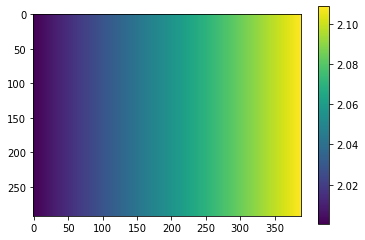

In [33]:
plt.figure()
plt.imshow(X)
plt.colorbar()
plt.show

In [41]:
x = X.flatten()
y = Y.flatten()
z = np.flipud(data_array).flatten()

In [42]:
xyzfile = 'tmp.xyz'

f = open(xyzfile, 'w')
for i in range(0, np.shape(x)[0]):
    f.write('{}, {}, {}\n'.format(x[i], y[i], -z[i]))
f.close()